In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from imblearn.over_sampling import SMOTE
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*100)
print("BANK MARKETING DATASET - COMPREHENSIVE ANALYSIS")
print("="*100)

BANK MARKETING DATASET - COMPREHENSIVE ANALYSIS


In [64]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

print(f"\n{'='*100}")
print("1. DATASET OVERVIEW")
print(f"{'='*100}")
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Records: {df.shape[0]:,}")
print(f"Number of Features: {df.shape[1]}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "-"*100)
print("First 5 Records:")
print("-"*100)
print(df.head())

print("\n" + "-"*100)
print("Dataset Information:")
print("-"*100)
df.info()


1. DATASET OVERVIEW

Dataset Shape: (41188, 21)
Number of Records: 41,188
Number of Features: 21

Memory Usage: 26.80 MB

----------------------------------------------------------------------------------------------------
First 5 Records:
----------------------------------------------------------------------------------------------------
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    9

In [66]:
print(f"\n{'='*100}")
print("2. DATA QUALITY ASSESSMENT")
print(f"{'='*100}")

# Missing values
print("\nMissing Values Analysis:")
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("✓ No missing values detected - Dataset is complete!")
else:
    print(missing_data[missing_data > 0])

# Duplicate records
duplicates = df.duplicated().sum()
print(f"\nDuplicate Records: {duplicates}")
if duplicates > 0:
    print(f"  → {duplicates} duplicate rows found ({duplicates/len(df)*100:.2f}%)")
else:
    print("✓ No duplicate records found")

# Data types
print("\nData Types Distribution:")
print(df.dtypes.value_counts())

# Unique values for categorical features
print("\nCategorical Features - Unique Values:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"  {col:20s}: {df[col].nunique():3d} unique values")


2. DATA QUALITY ASSESSMENT

Missing Values Analysis:
✓ No missing values detected - Dataset is complete!

Duplicate Records: 12
  → 12 duplicate rows found (0.03%)

Data Types Distribution:
object     11
int64       5
float64     5
Name: count, dtype: int64

Categorical Features - Unique Values:
  job                 :  12 unique values
  marital             :   4 unique values
  education           :   8 unique values
  default             :   3 unique values
  housing             :   3 unique values
  loan                :   3 unique values
  contact             :   2 unique values
  month               :  10 unique values
  day_of_week         :   5 unique values
  poutcome            :   3 unique values
  y                   :   2 unique values


In [68]:
# ============================================================================
# PART 3: TARGET VARIABLE ANALYSIS
# ============================================================================

print(f"\n{'='*100}")
print("3. TARGET VARIABLE ANALYSIS")
print(f"{'='*100}")

target_counts = df['y'].value_counts()
target_percentages = df['y'].value_counts(normalize=True) * 100

print("\nTarget Variable Distribution:")
print(f"  No  (Class 0): {target_counts['no']:,} ({target_percentages['no']:.2f}%)")
print(f"  Yes (Class 1): {target_counts['yes']:,} ({target_percentages['yes']:.2f}%)")
print(f"\nClass Imbalance Ratio: {target_counts['no']/target_counts['yes']:.2f}:1")
print("Severe class imbalance detected - SMOTE will be required")


3. TARGET VARIABLE ANALYSIS

Target Variable Distribution:
  No  (Class 0): 36,548 (88.73%)
  Yes (Class 1): 4,640 (11.27%)

Class Imbalance Ratio: 7.88:1
Severe class imbalance detected - SMOTE will be required


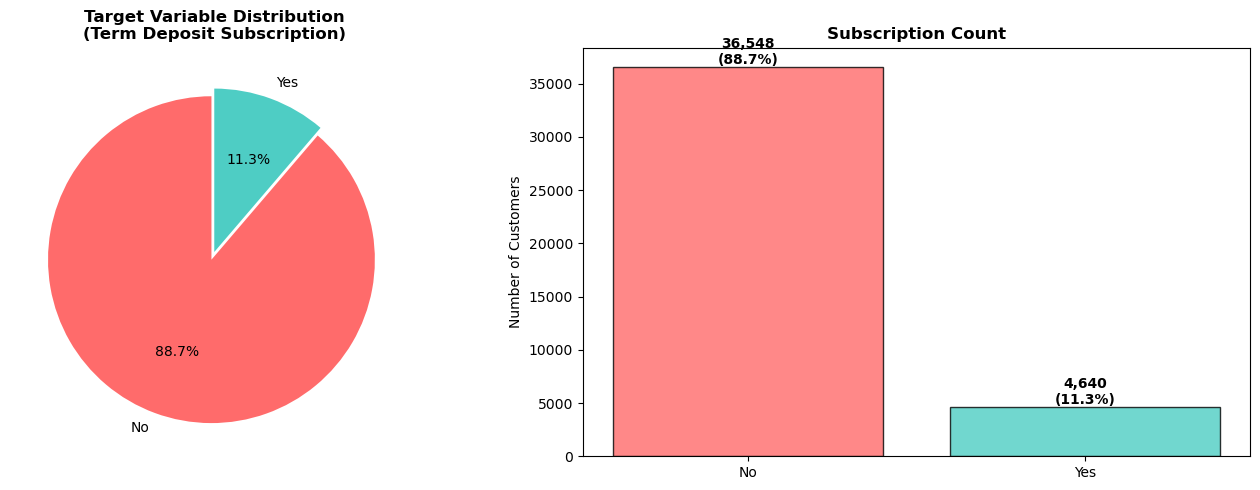


✓ Saved: 01_target_distribution.png


In [70]:
# Visualization: Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
axes[0].pie(target_counts, labels=['No', 'Yes'], autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=(0.05, 0))
axes[0].set_title('Target Variable Distribution\n(Term Deposit Subscription)', 
                  fontsize=12, fontweight='bold')

# Bar chart
bars = axes[1].bar(['No', 'Yes'], target_counts, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_title('Subscription Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Customers', fontsize=10)
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}\n({target_percentages.iloc[i]:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 01_target_distribution.png")


In [72]:
# PART 4: COMPREHENSIVE EXPLORATORY DATA ANALYSIS

print(f"\n{'='*100}")
print("4. COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)")
print(f"{'='*100}")

# 4.1: Numerical Features Analysis
print("\n" + "-"*100)
print("4.1 NUMERICAL FEATURES ANALYSIS")
print("-"*100)

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('y') if 'y' in numerical_features else None

print(f"\nNumerical Features ({len(numerical_features)}):")
print(", ".join(numerical_features))

print("\nDescriptive Statistics:")
print(df[numerical_features].describe().round(2))


4. COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)

----------------------------------------------------------------------------------------------------
4.1 NUMERICAL FEATURES ANALYSIS
----------------------------------------------------------------------------------------------------

Numerical Features (10):
age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Descriptive Statistics:
            age  duration  campaign     pdays  previous  emp.var.rate  \
count  41188.00  41188.00  41188.00  41188.00  41188.00      41188.00   
mean      40.02    258.29      2.57    962.48      0.17          0.08   
std       10.42    259.28      2.77    186.91      0.49          1.57   
min       17.00      0.00      1.00      0.00      0.00         -3.40   
25%       32.00    102.00      1.00    999.00      0.00         -1.80   
50%       38.00    180.00      2.00    999.00      0.00          1.10   
75%       47.00    319.00      3.00    999.

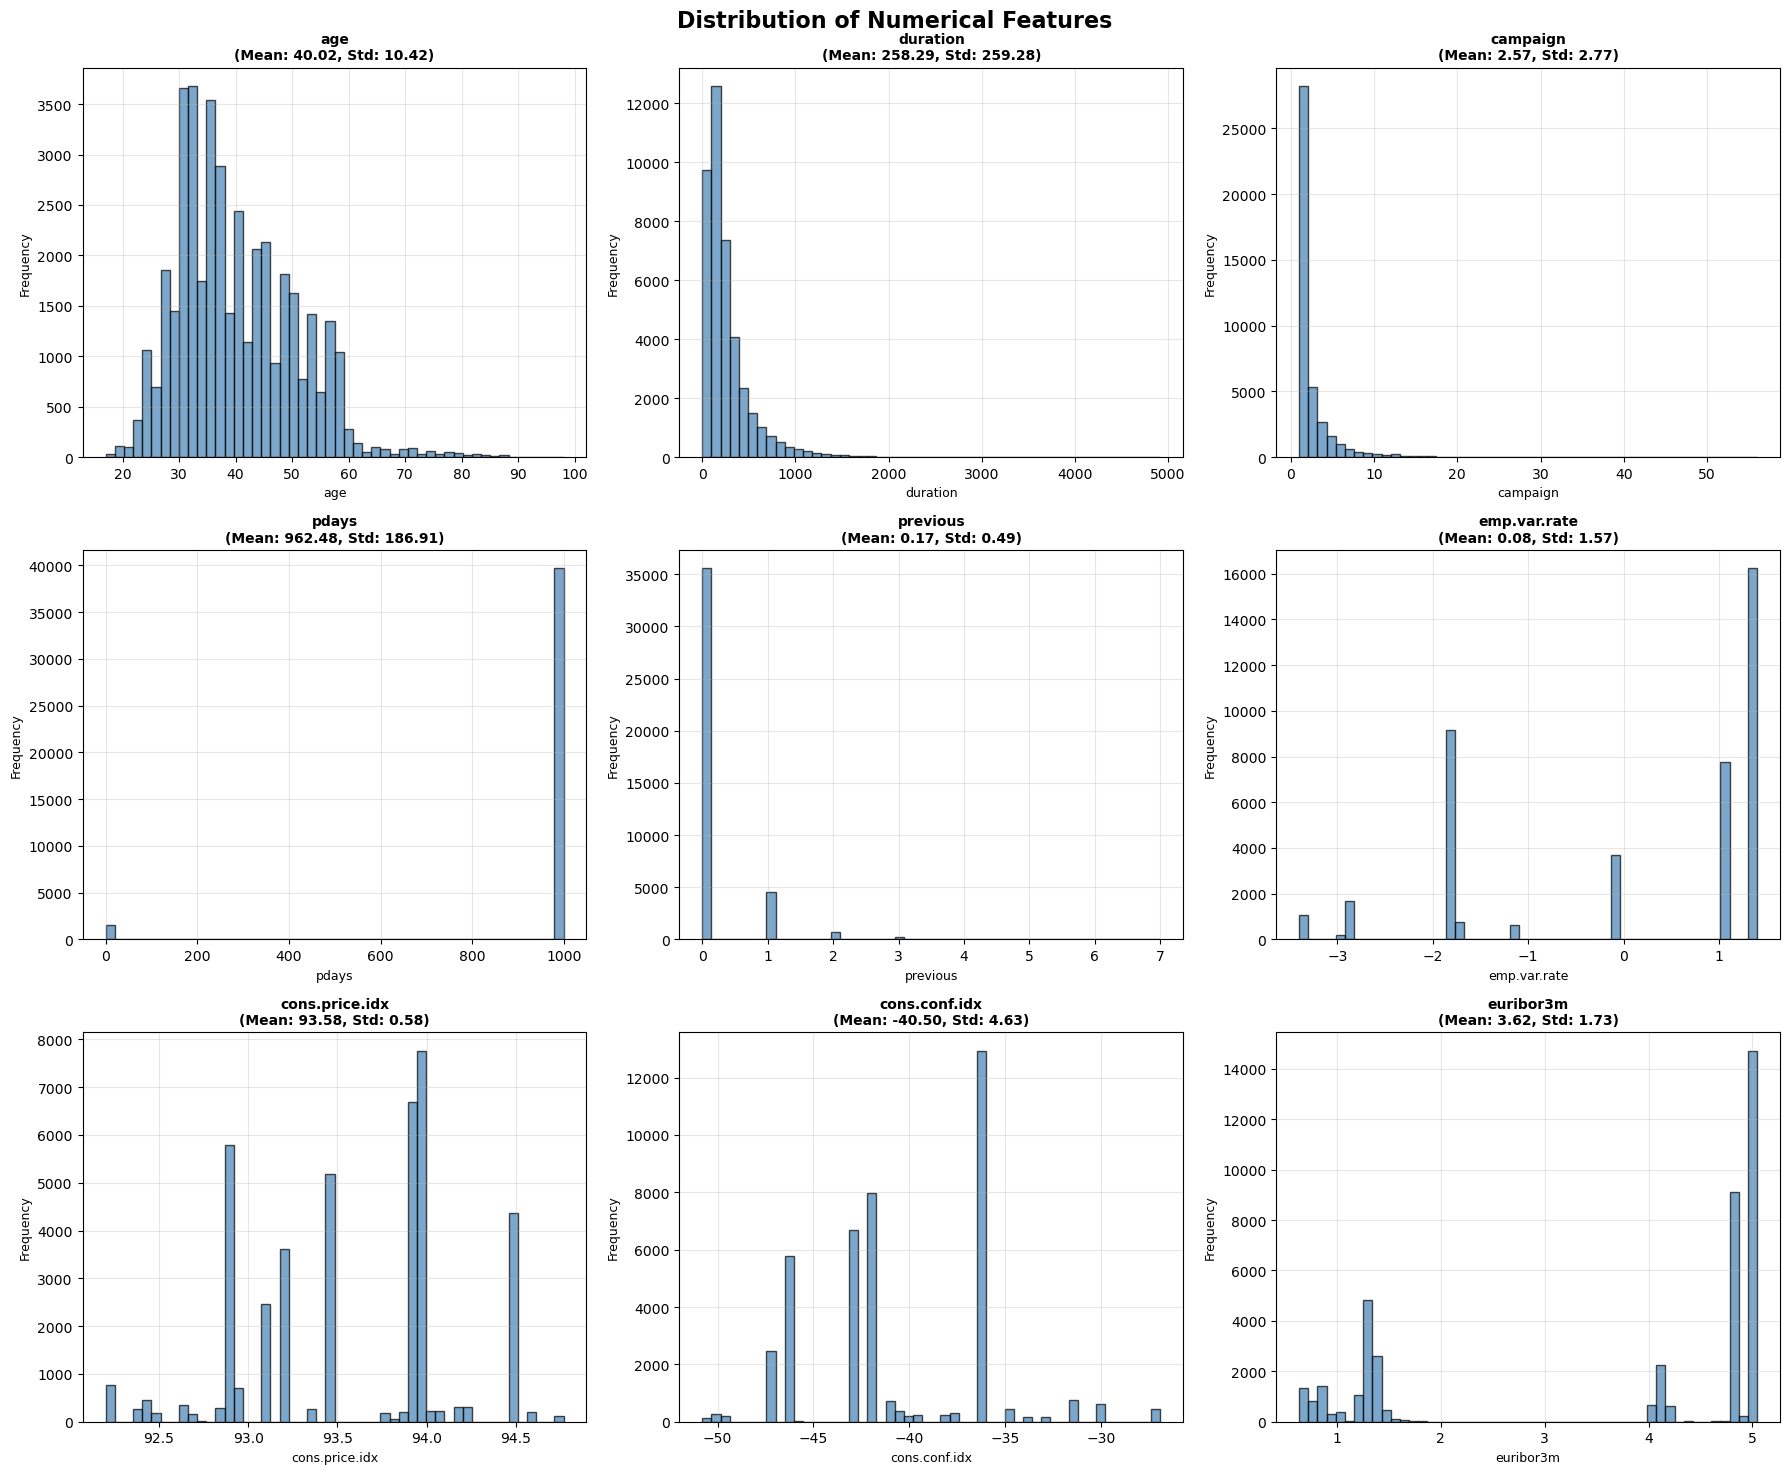


✓ Saved: 02_numerical_distributions.png


In [74]:
# Distribution plots for numerical features
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        # Histogram with KDE
        axes[idx].hist(df[col], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}\n(Mean: {df[col].mean():.2f}, Std: {df[col].std():.2f})',
                           fontsize=10, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)
        axes[idx].grid(alpha=0.3)

plt.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('02_numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 02_numerical_distributions.png")


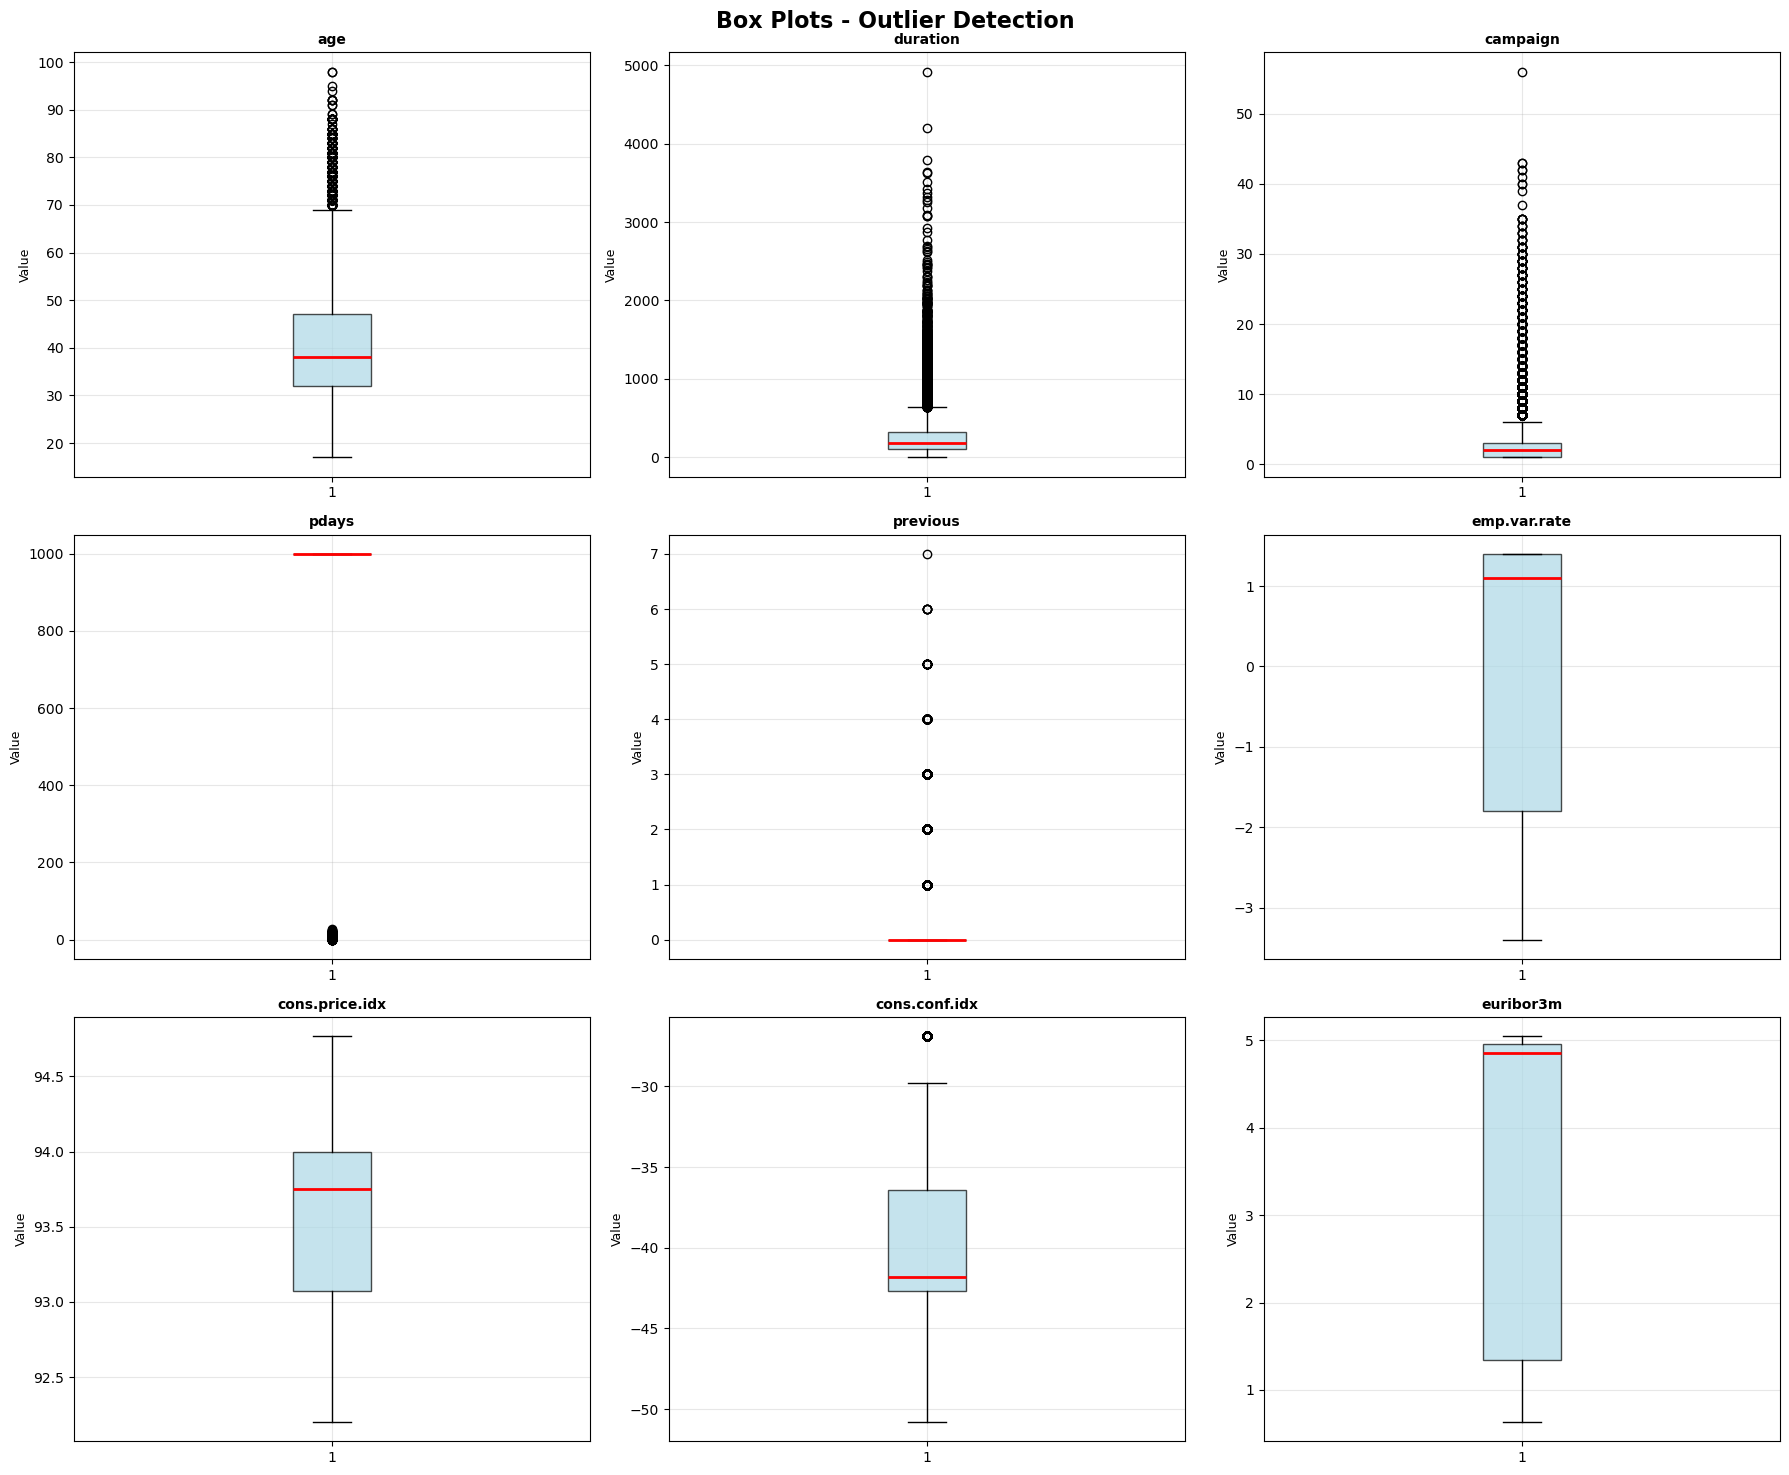

✓ Saved: 03_boxplots_outliers.png

Outlier Analysis (Using IQR Method):
  age                 :   469 outliers ( 1.14%)
  duration            :  2963 outliers ( 7.19%)
  campaign            :  2406 outliers ( 5.84%)
  pdays               :  1515 outliers ( 3.68%)
  previous            :  5625 outliers (13.66%)
  emp.var.rate        :     0 outliers ( 0.00%)
  cons.price.idx      :     0 outliers ( 0.00%)
  cons.conf.idx       :   447 outliers ( 1.09%)
  euribor3m           :     0 outliers ( 0.00%)
  nr.employed         :     0 outliers ( 0.00%)


In [76]:
# Box plots to detect outliers
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    if idx < len(axes):
        bp = axes[idx].boxplot(df[col], vert=True, patch_artist=True,
                               boxprops=dict(facecolor='lightblue', alpha=0.7),
                               medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[idx].set_ylabel('Value', fontsize=9)
        axes[idx].grid(alpha=0.3)

plt.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('03_boxplots_outliers.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 03_boxplots_outliers.png")

# Outlier statistics
print("\nOutlier Analysis (Using IQR Method):")
for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(df)) * 100
    print(f"  {col:20s}: {outliers:5d} outliers ({outlier_pct:5.2f}%)")


In [78]:
print("\n" + "-"*100)
print("4.2 CATEGORICAL FEATURES ANALYSIS")
print("-"*100)

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('y')

print(f"\nCategorical Features ({len(categorical_features)}):")
for col in categorical_features:
    print(f"  {col:20s}: {df[col].nunique()} categories - {list(df[col].unique()[:5])}")



----------------------------------------------------------------------------------------------------
4.2 CATEGORICAL FEATURES ANALYSIS
----------------------------------------------------------------------------------------------------

Categorical Features (10):
  job                 : 12 categories - ['housemaid', 'services', 'admin.', 'blue-collar', 'technician']
  marital             : 4 categories - ['married', 'single', 'divorced', 'unknown']
  education           : 8 categories - ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course']
  default             : 3 categories - ['no', 'unknown', 'yes']
  housing             : 3 categories - ['no', 'yes', 'unknown']
  loan                : 3 categories - ['no', 'yes', 'unknown']
  contact             : 2 categories - ['telephone', 'cellular']
  month               : 10 categories - ['may', 'jun', 'jul', 'aug', 'oct']
  day_of_week         : 5 categories - ['mon', 'tue', 'wed', 'thu', 'fri']
  poutcome            : 

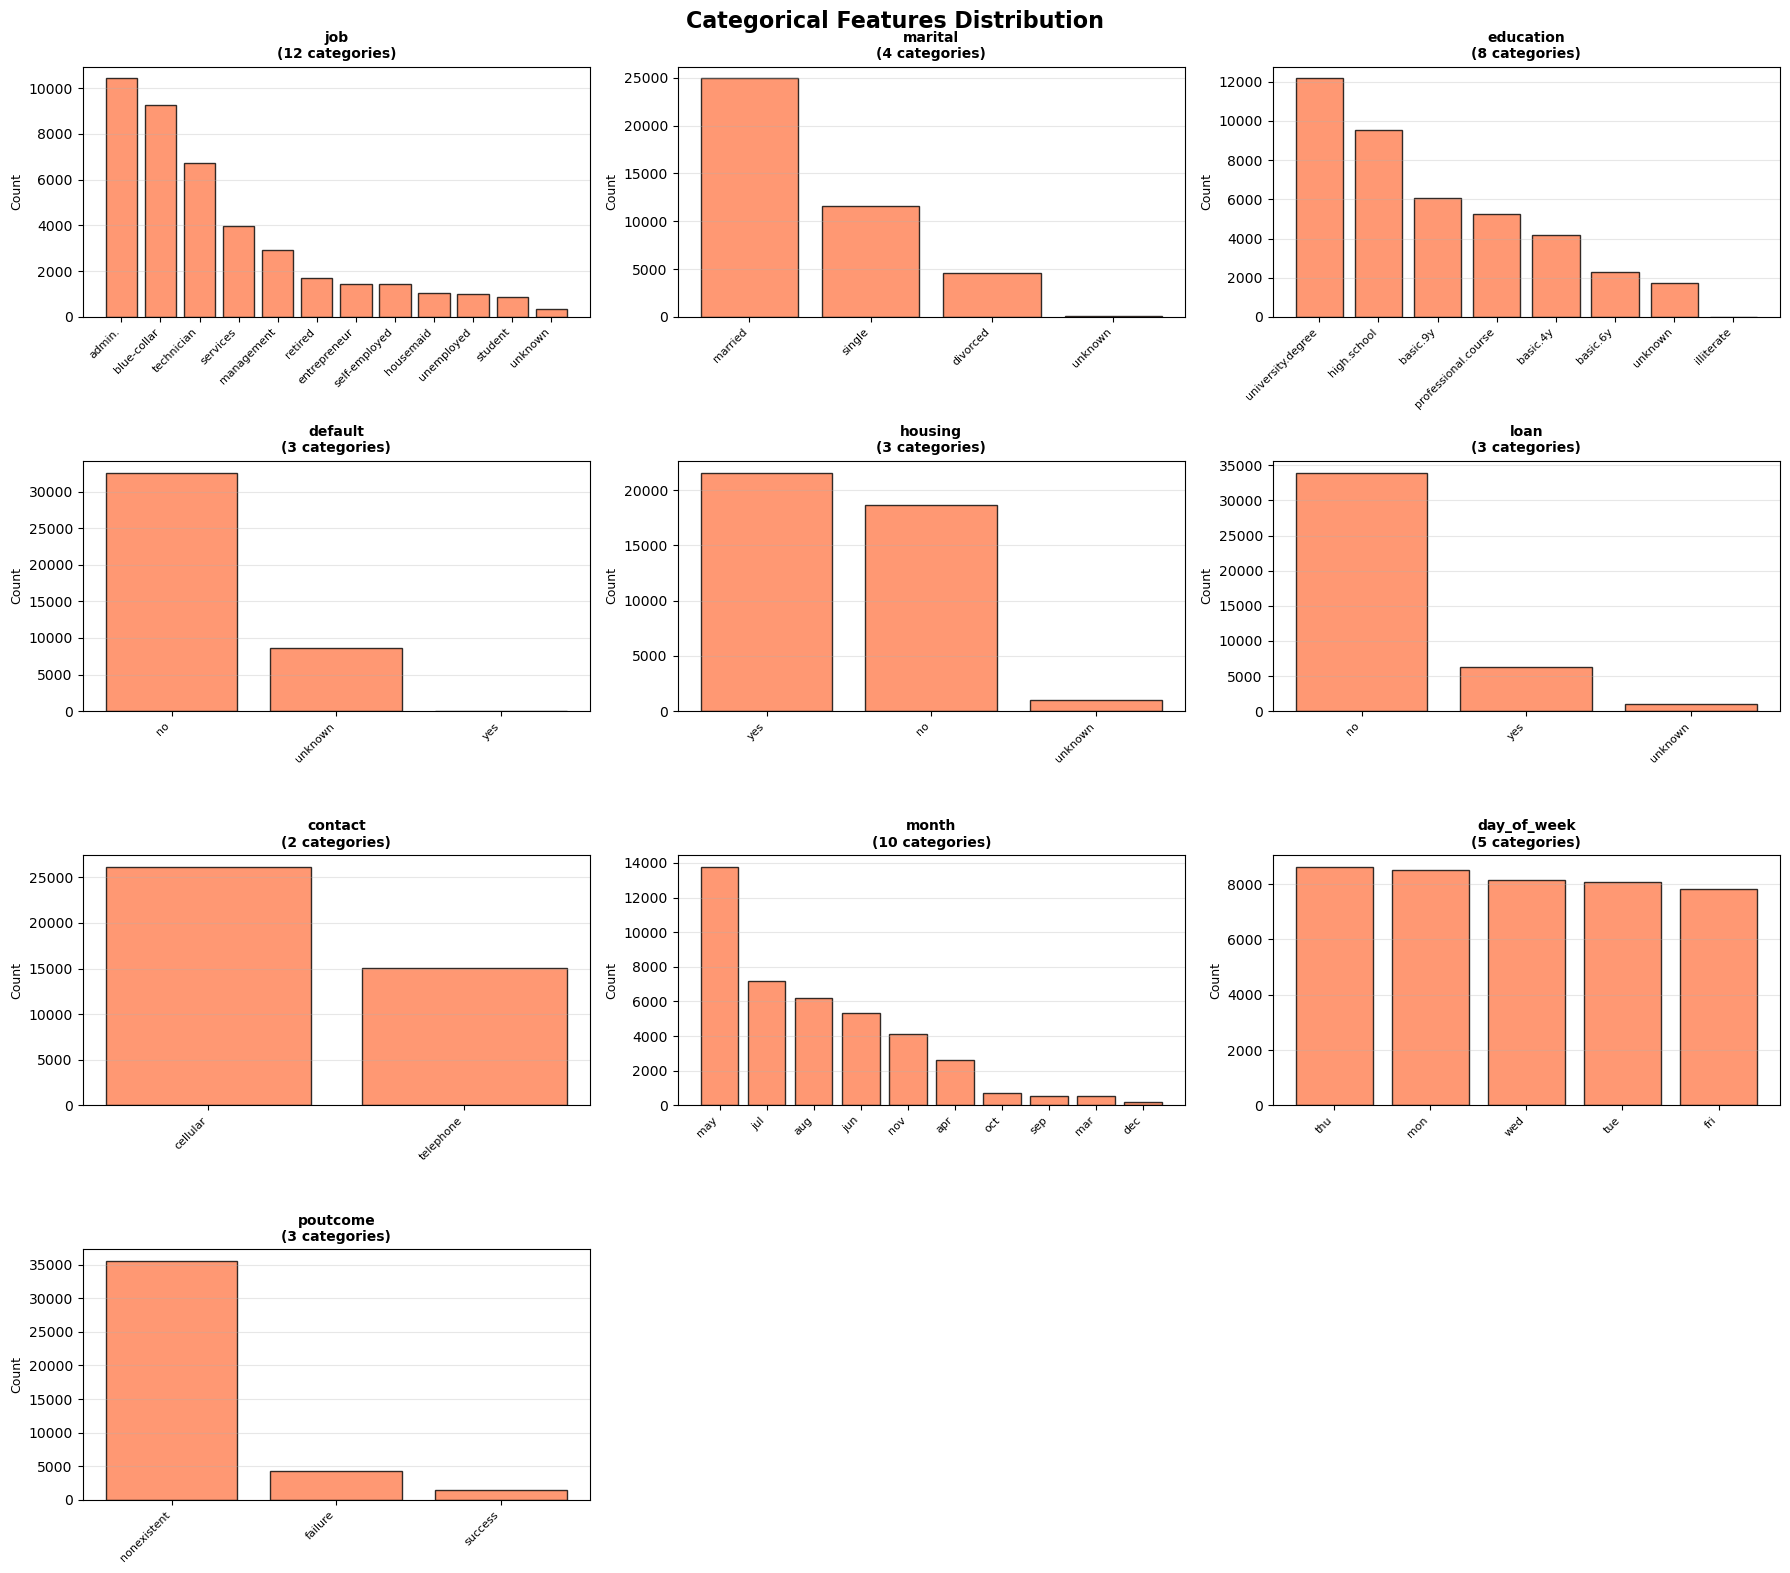


✓ Saved: 04_categorical_distributions.png


In [80]:
# Categorical feature distributions
n_cat_features = len(categorical_features)
n_rows = (n_cat_features + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    if idx < len(axes):
        value_counts = df[col].value_counts()
        bars = axes[idx].bar(range(len(value_counts)), value_counts.values,
                            color='coral', edgecolor='black', alpha=0.8)
        axes[idx].set_title(f'{col}\n({df[col].nunique()} categories)',
                           fontsize=10, fontweight='bold')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)
        axes[idx].set_ylabel('Count', fontsize=9)
        axes[idx].grid(alpha=0.3, axis='y')

# Remove empty subplots
for idx in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Categorical Features Distribution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('04_categorical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 04_categorical_distributions.png")

In [82]:
# 4.3: Correlation Analysis
print("\n" + "-"*100)
print("4.3 CORRELATION ANALYSIS")
print("-"*100)

# Encode target for correlation
df_corr = df.copy()
df_corr['y'] = df_corr['y'].map({'yes': 1, 'no': 0})

# Correlation matrix
correlation_matrix = df_corr[numerical_features + ['y']].corr()

print("\nTop 10 Features Correlated with Target Variable:")
target_corr = correlation_matrix['y'].abs().sort_values(ascending=False)[1:11]
print(target_corr)



----------------------------------------------------------------------------------------------------
4.3 CORRELATION ANALYSIS
----------------------------------------------------------------------------------------------------

Top 10 Features Correlated with Target Variable:
duration          0.405274
nr.employed       0.354678
pdays             0.324914
euribor3m         0.307771
emp.var.rate      0.298334
previous          0.230181
cons.price.idx    0.136211
campaign          0.066357
cons.conf.idx     0.054878
age               0.030399
Name: y, dtype: float64


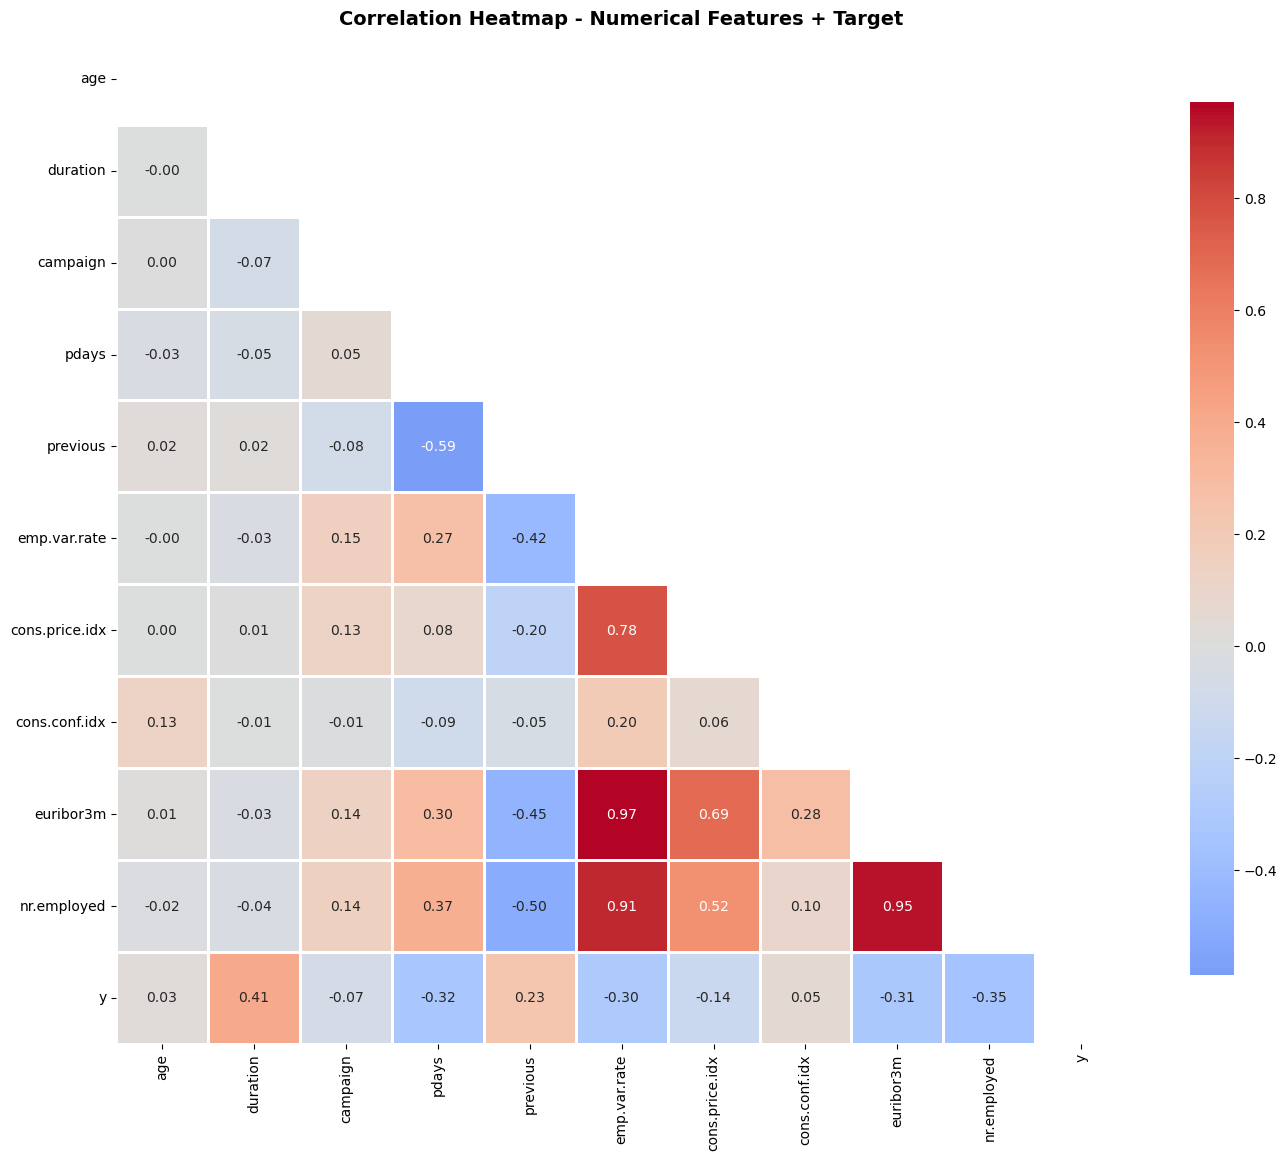


✓ Saved: 05_correlation_heatmap.png


In [84]:
# Heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Numerical Features + Target', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('05_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 05_correlation_heatmap.png")



5. DURATION COLUMN ANALYSIS - CRITICAL DECISION

DURATION COLUMN ISSUE:
----------------------------------------------------------------------------------------------------

The 'duration' feature represents the last contact duration in seconds during the campaign.

KEY PROBLEM:
• Duration is ONLY known AFTER the call is completed
• This value is NOT available BEFORE making a marketing call
• Including it creates DATA LEAKAGE - using future information to predict outcomes

STATISTICAL EVIDENCE:

       count        mean         std   min    25%    50%     75%     max
y                                                                       
no   36548.0  220.844807  207.096293   0.0   95.0  163.5  279.00  4918.0
yes   4640.0  553.191164  401.171871  37.0  253.0  449.0  741.25  4199.0

Correlation with Target: 0.4053

Duration Distribution by Subscription:
  Subscribers:     Mean = 553.2s, Median = 449.0s
  Non-subscribers: Mean = 220.8s, Median = 163.5s


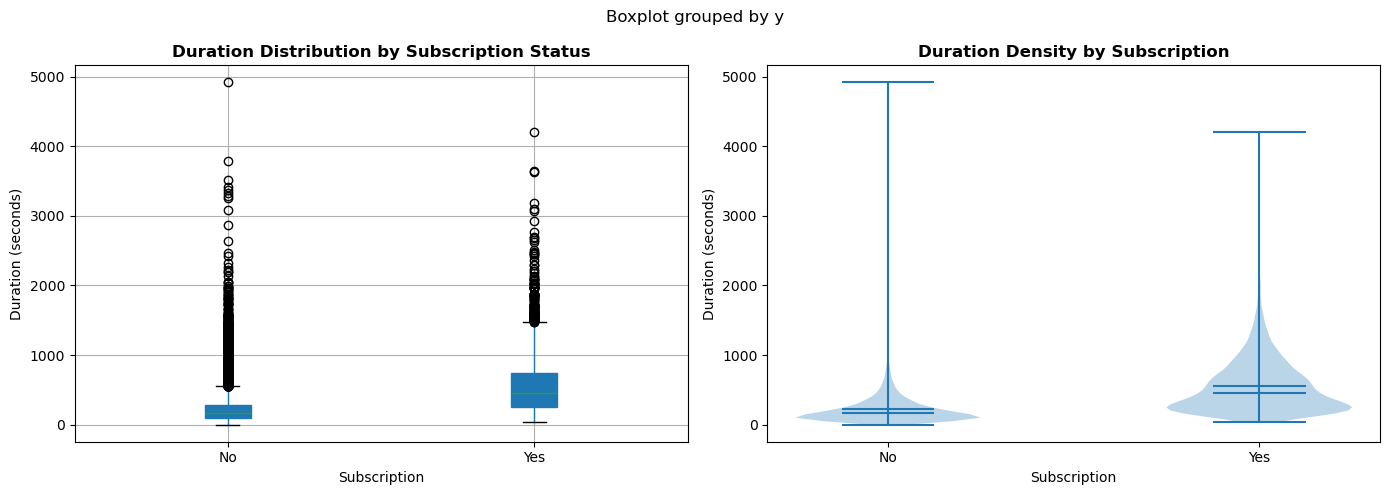


✓ Saved: 08_duration_analysis.png

DECISION: DURATION WILL BE REMOVED

JUSTIFICATION:
✓ Prevents data leakage - ensures realistic predictions
✓ Model will work with information available BEFORE calling customer
✓ Aligns with real-world deployment scenario
✓ Maintains scientific rigor and model validity

This approach ensures the model can be deployed in production to prioritize
customers BEFORE making calls, which is the actual business use case.



In [86]:
# ============================================================================
# PART 5: DURATION COLUMN ANALYSIS AND DECISION
# ============================================================================

print(f"\n{'='*100}")
print("5. DURATION COLUMN ANALYSIS - CRITICAL DECISION")
print(f"{'='*100}")

print("\nDURATION COLUMN ISSUE:")
print("-" * 100)
print("""
The 'duration' feature represents the last contact duration in seconds during the campaign.

KEY PROBLEM:
• Duration is ONLY known AFTER the call is completed
• This value is NOT available BEFORE making a marketing call
• Including it creates DATA LEAKAGE - using future information to predict outcomes

STATISTICAL EVIDENCE:
""")

# Analyze duration's relationship with target
duration_stats = df.groupby('y')['duration'].describe()
print(duration_stats)

print(f"\nCorrelation with Target: {df_corr[['duration', 'y']].corr().iloc[0, 1]:.4f}")
print("\nDuration Distribution by Subscription:")
print(f"  Subscribers:     Mean = {df[df['y']=='yes']['duration'].mean():.1f}s, "
      f"Median = {df[df['y']=='yes']['duration'].median():.1f}s")
print(f"  Non-subscribers: Mean = {df[df['y']=='no']['duration'].mean():.1f}s, "
      f"Median = {df[df['y']=='no']['duration'].median():.1f}s")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df.boxplot(column='duration', by='y', ax=axes[0], patch_artist=True)
axes[0].set_title('Duration Distribution by Subscription Status', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Subscription', fontsize=10)
axes[0].set_ylabel('Duration (seconds)', fontsize=10)
plt.sca(axes[0])
plt.xticks([1, 2], ['No', 'Yes'])

# Violin plot
parts = axes[1].violinplot([df[df['y']=='no']['duration'], 
                            df[df['y']=='yes']['duration']], 
                           positions=[1, 2], showmeans=True, showmedians=True)
axes[1].set_title('Duration Density by Subscription', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Subscription', fontsize=10)
axes[1].set_ylabel('Duration (seconds)', fontsize=10)
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.savefig('08_duration_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 08_duration_analysis.png")

print("\n" + "="*100)
print("DECISION: DURATION WILL BE REMOVED")
print("="*100)
print("""
JUSTIFICATION:
✓ Prevents data leakage - ensures realistic predictions
✓ Model will work with information available BEFORE calling customer
✓ Aligns with real-world deployment scenario
✓ Maintains scientific rigor and model validity

This approach ensures the model can be deployed in production to prioritize
customers BEFORE making calls, which is the actual business use case.
""")


In [88]:
# ============================================================================
# PART 6: DATA PREPROCESSING
# ============================================================================

print(f"\n{'='*100}")
print("6. DATA PREPROCESSING")
print(f"{'='*100}")

# Create preprocessing copy
data = df.copy()

# 6.1: Encode target variable
data['y'] = data['y'].map({'yes': 1, 'no': 0})
print("\n✓ Target variable encoded: yes=1, no=0")



6. DATA PREPROCESSING

✓ Target variable encoded: yes=1, no=0


In [90]:
# 6.2: Remove duration
if 'duration' in data.columns:
    data = data.drop('duration', axis=1)
    print("✓ Duration column removed (prevents data leakage)")


✓ Duration column removed (prevents data leakage)


In [92]:
# 6.3: Identify feature types
numerical_features_final = ['age', 'campaign', 'pdays', 'previous',
                            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                            'euribor3m', 'nr.employed']

categorical_features_final = ['job', 'marital', 'education', 'default', 'housing', 
                              'loan', 'contact', 'month', 'day_of_week', 'poutcome']

print(f"\n✓ Numerical features: {len(numerical_features_final)}")
print(f"✓ Categorical features: {len(categorical_features_final)}")



✓ Numerical features: 9
✓ Categorical features: 10


In [94]:
 #6.4: One-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_features_final, drop_first=True)
print(f"\n✓ One-hot encoding completed")
print(f"  Original features: {len(data.columns) - 1}")
print(f"  Encoded features: {len(data_encoded.columns) - 1}")


✓ One-hot encoding completed
  Original features: 19
  Encoded features: 52


In [96]:
# 6.5: Prepare features and target
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

print(f"\nFinal dataset shape:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")



Final dataset shape:
  Features (X): (41188, 52)
  Target (y): (41188,)


In [98]:
# 6.6: Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain-Test Split (80-20 with stratification):")
print(f"  Training samples: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test samples: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Training class distribution: No={sum(y_train==0):,}, Yes={sum(y_train==1):,}")
print(f"  Test class distribution: No={sum(y_test==0):,}, Yes={sum(y_test==1):,}")



Train-Test Split (80-20 with stratification):
  Training samples: 32,950 (80.0%)
  Test samples: 8,238 (20.0%)
  Training class distribution: No=29,238, Yes=3,712
  Test class distribution: No=7,310, Yes=928


In [100]:
# 6.7: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Feature scaling completed using StandardScaler")
print(f"  Scaler fitted on training data only (prevents data leakage)")



✓ Feature scaling completed using StandardScaler
  Scaler fitted on training data only (prevents data leakage)


In [102]:
# ============================================================================
# PART 7: HANDLING CLASS IMBALANCE WITH SMOTE
# ============================================================================

print(f"\n{'='*100}")
print("7. HANDLING CLASS IMBALANCE - SMOTE")
print(f"{'='*100}")

print(f"\nBefore SMOTE (Training Set):")
print(f"  Class 0 (No): {sum(y_train == 0):,} samples ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  Class 1 (Yes): {sum(y_train == 1):,} samples ({sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"  Imbalance ratio: {sum(y_train == 0) / sum(y_train == 1):.2f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE (Training Set):")
print(f"  Class 0 (No): {sum(y_train_balanced == 0):,} samples ({sum(y_train_balanced == 0)/len(y_train_balanced)*100:.2f}%)")
print(f"  Class 1 (Yes): {sum(y_train_balanced == 1):,} samples ({sum(y_train_balanced == 1)/len(y_train_balanced)*100:.2f}%)")
print(f"  ✓ Perfect balance achieved: 1:1 ratio")



7. HANDLING CLASS IMBALANCE - SMOTE

Before SMOTE (Training Set):
  Class 0 (No): 29,238 samples (88.73%)
  Class 1 (Yes): 3,712 samples (11.27%)
  Imbalance ratio: 7.88:1

After SMOTE (Training Set):
  Class 0 (No): 29,238 samples (50.00%)
  Class 1 (Yes): 29,238 samples (50.00%)
  ✓ Perfect balance achieved: 1:1 ratio


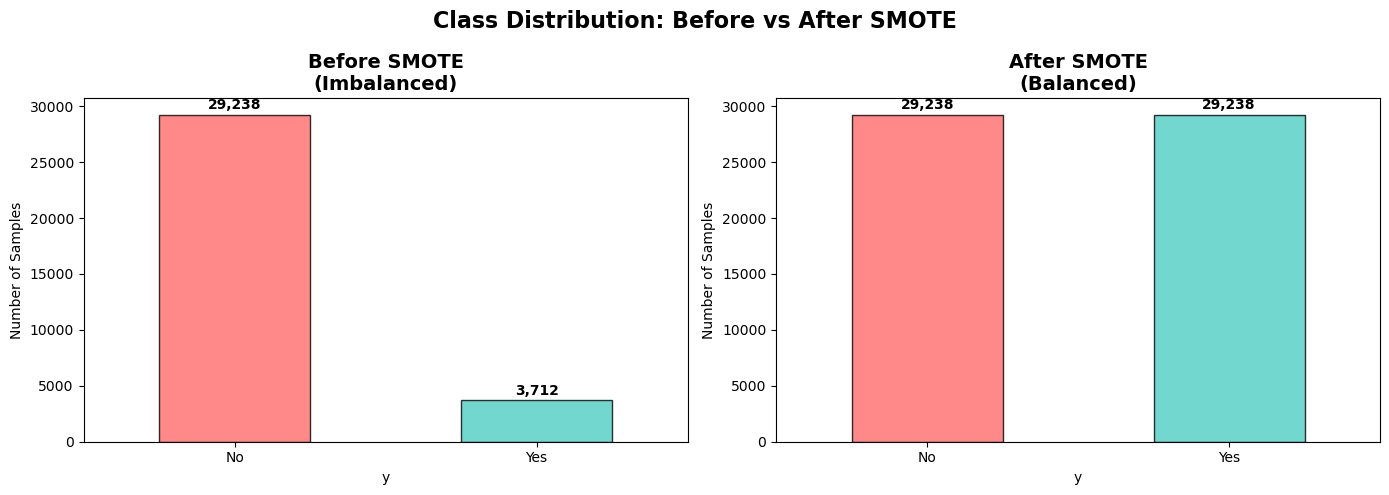


✓ Saved: 09_smote_comparison.png

Preprocessing Complete - Ready for Model Training


In [104]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], 
                                       color=['#FF6B6B', '#4ECDC4'], 
                                       edgecolor='black', alpha=0.8)
axes[0].set_title('Before SMOTE\n(Imbalanced)', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)
axes[0].set_ylabel('Number of Samples', fontsize=10)
for i, v in enumerate(pd.Series(y_train).value_counts().values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1],
                                                color=['#FF6B6B', '#4ECDC4'],
                                                edgecolor='black', alpha=0.8)
axes[1].set_title('After SMOTE\n(Balanced)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(['No', 'Yes'], rotation=0)
axes[1].set_ylabel('Number of Samples', fontsize=10)
for i, v in enumerate(pd.Series(y_train_balanced).value_counts().values):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.suptitle('Class Distribution: Before vs After SMOTE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('09_smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 09_smote_comparison.png")

print("\n" + "="*100)
print("Preprocessing Complete - Ready for Model Training")
print("="*100)


In [106]:
# ============================================================================
# PART 8: OPTIMIZED MODEL TRAINING (LEAKAGE-FREE VERSION)
# ============================================================================

print(f"\n{'='*100}")
print("8. MODEL TRAINING - OPTIMIZED")
print(f"{'='*100}")

import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Define pipelines (SMOTE INSIDE CV)
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ]),
    
    'Random Forest': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    
    
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', KNeighborsClassifier(n_jobs=-1))
    ]),
    
    'XGBoost': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        ))
    ]),
     'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', SVC(probability=True, random_state=42, cache_size=1000))
    ])
}

# Parameter grids (NOTE: prefix with model__)
param_grids = {
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, 30],
        'model__min_samples_split': [2, 5]
    },
    'SVM': {
        'model__C': [1, 10],
        'model__kernel': ['rbf'],
        'model__gamma': ['scale']
    },
    'KNN': {
        'model__n_neighbors': [5, 7, 9],
        'model__weights': ['distance']
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 7],
        'model__learning_rate': [0.1, 0.2]
    }
}

# Store results
results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'='*100}")
    print(f"Training: {name}")
    print(f"{'='*100}")
    
    start_time = time.time()
    
    if name in ['Random Forest', 'XGBoost']:
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grids[name],
            n_iter=8,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
    else:
        search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=0
        )
    
    print("  Status: Training in progress...")
    search.fit(X_train, y_train)  # IMPORTANT: no pre-balancing
    
    training_time = time.time() - start_time
    
    print("  ✓ Training Complete")
    print(f"  Best Parameters: {search.best_params_}")
    print(f"  Best CV F1-Score: {search.best_score_:.4f}")
    print(f"  Training Time: {training_time:.2f} seconds")
    
    best_model = search.best_estimator_
    
    # Test predictions (NO SMOTE HERE)
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': best_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'training_time': training_time,
        'best_params': search.best_params_,
        'cv_score': search.best_score_
    }
    
    print("\n  Test Set Performance:")
    print(f"    Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-Score:  {f1:.4f}")
    print(f"    ROC-AUC:   {roc_auc:.4f}")

print(f"\n{'='*100}")
print("All Models Trained Successfully")
print(f"Total Training Time: {sum(results[m]['training_time'] for m in results):.2f} seconds")
print(f"{'='*100}")



8. MODEL TRAINING - OPTIMIZED

Training: Logistic Regression
  Status: Training in progress...
  ✓ Training Complete
  Best Parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
  Best CV F1-Score: 0.4372
  Training Time: 4.69 seconds

  Test Set Performance:
    Accuracy:  0.8241 (82.41%)
    Precision: 0.3507
    Recall:    0.6595
    F1-Score:  0.4579
    ROC-AUC:   0.7999

Training: Random Forest
  Status: Training in progress...
  ✓ Training Complete
  Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 10}
  Best CV F1-Score: 0.4804
  Training Time: 18.35 seconds

  Test Set Performance:
    Accuracy:  0.8696 (86.96%)
    Precision: 0.4431
    Recall:    0.6131
    F1-Score:  0.5145
    ROC-AUC:   0.8033

Training: KNN
  Status: Training in progress...
  ✓ Training Complete
  Best Parameters: {'model__n_neighbors': 7, 'model__weights': 'distance'}
  Best CV F1-Score: 0.3460
  Training Time: 4.58 seconds

  Tes

In [108]:
# ============================================================================
# PART 9: MODEL PERFORMANCE COMPARISON
# ============================================================================

print(f"\n{'='*100}")
print("9. MODEL PERFORMANCE COMPARISON")
print(f"{'='*100}")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()]
})

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\nModel Performance Summary:")
print("="*100)
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n{'='*100}")
print(f"BEST PERFORMING MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f}")
print(f"{'='*100}")


9. MODEL PERFORMANCE COMPARISON

Model Performance Summary:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Training Time (s)
      Random Forest  0.869629   0.443146 0.613147  0.514467 0.803250          18.352542
            XGBoost  0.885530   0.491892 0.490302  0.491096 0.790033           3.717179
                SVM  0.869264   0.435274 0.539871  0.481962 0.770781        2149.853724
Logistic Regression  0.824108   0.350716 0.659483  0.457912 0.799896           4.693019
                KNN  0.772396   0.265012 0.575431  0.362895 0.728716           4.577052

BEST PERFORMING MODEL: Random Forest
   F1-Score: 0.5145
   ROC-AUC: 0.8033



10. GENERATING PERFORMANCE VISUALIZATIONS


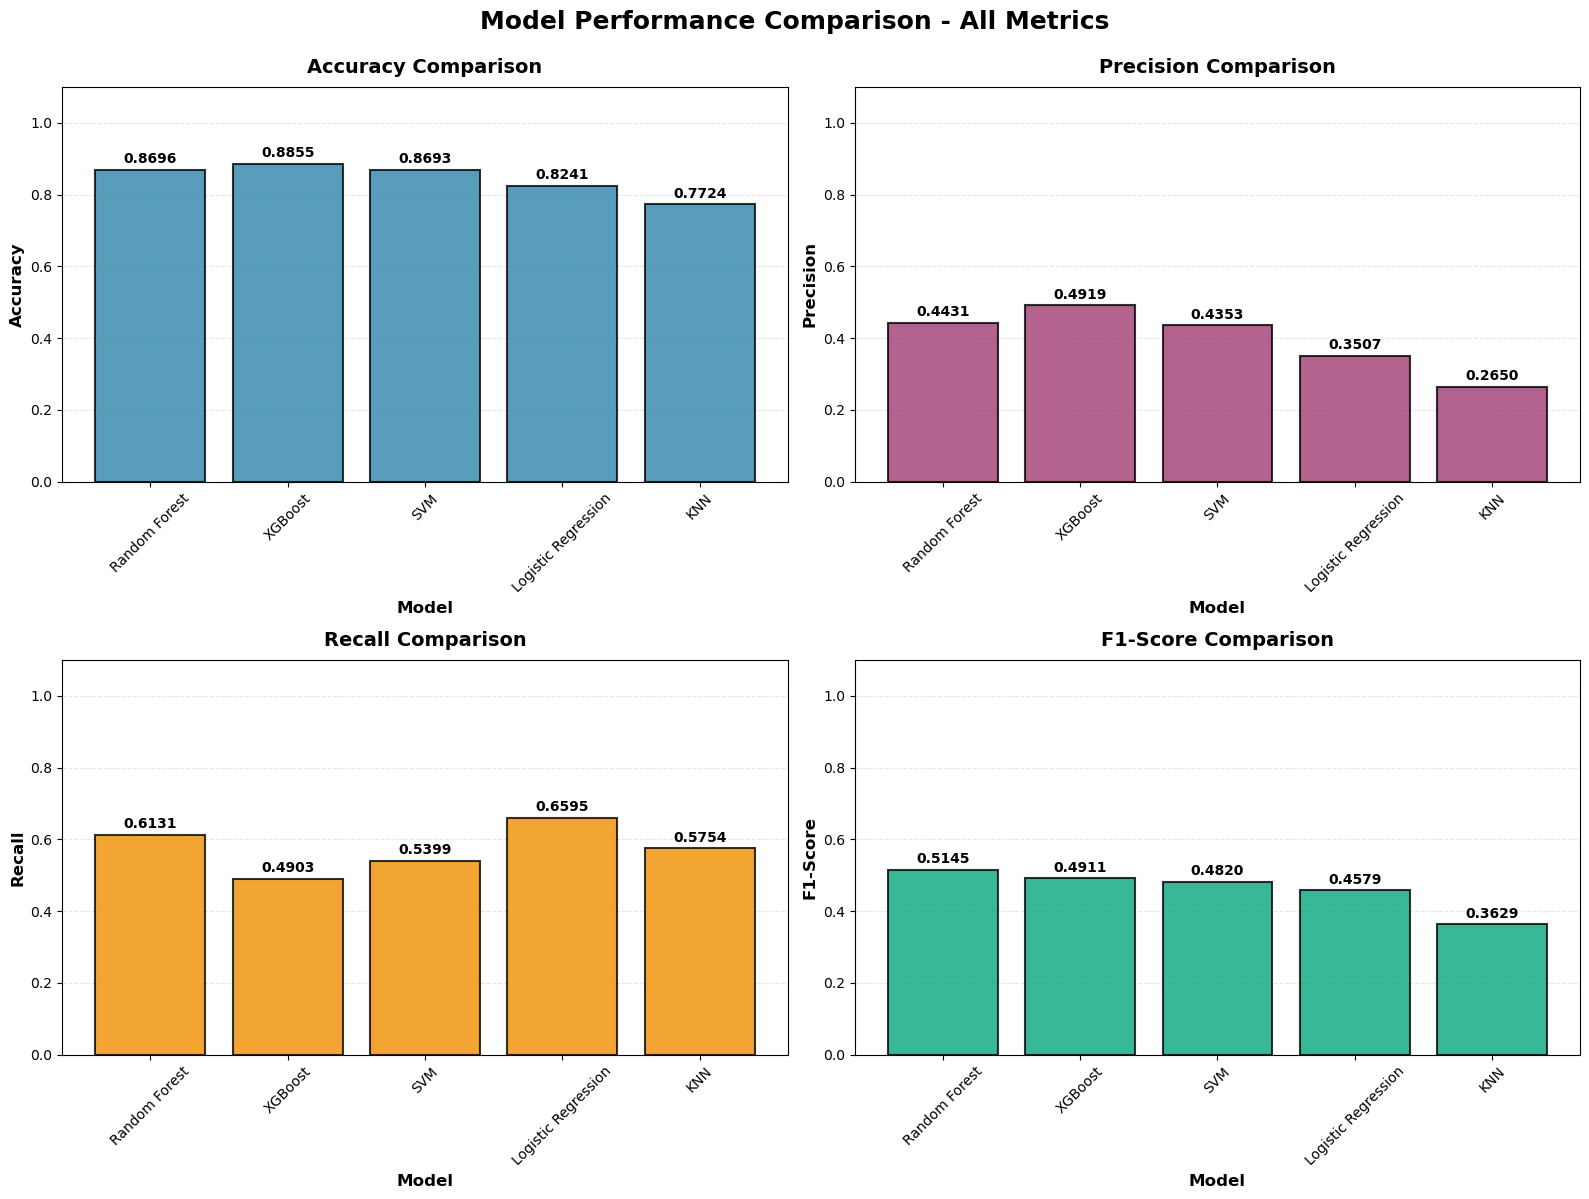


✓ Saved: 10_performance_comparison.png


In [110]:
# ============================================================================
# PART 10: VISUALIZATIONS - MODEL PERFORMANCE
# ============================================================================

print(f"\n{'='*100}")
print("10. GENERATING PERFORMANCE VISUALIZATIONS")
print(f"{'='*100}")

# Visualization 1: Performance Metrics Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_palette = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Create bar plot
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], 
                   color=colors_palette[idx], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Formatting
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

plt.suptitle('Model Performance Comparison - All Metrics', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('10_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 10_performance_comparison.png")


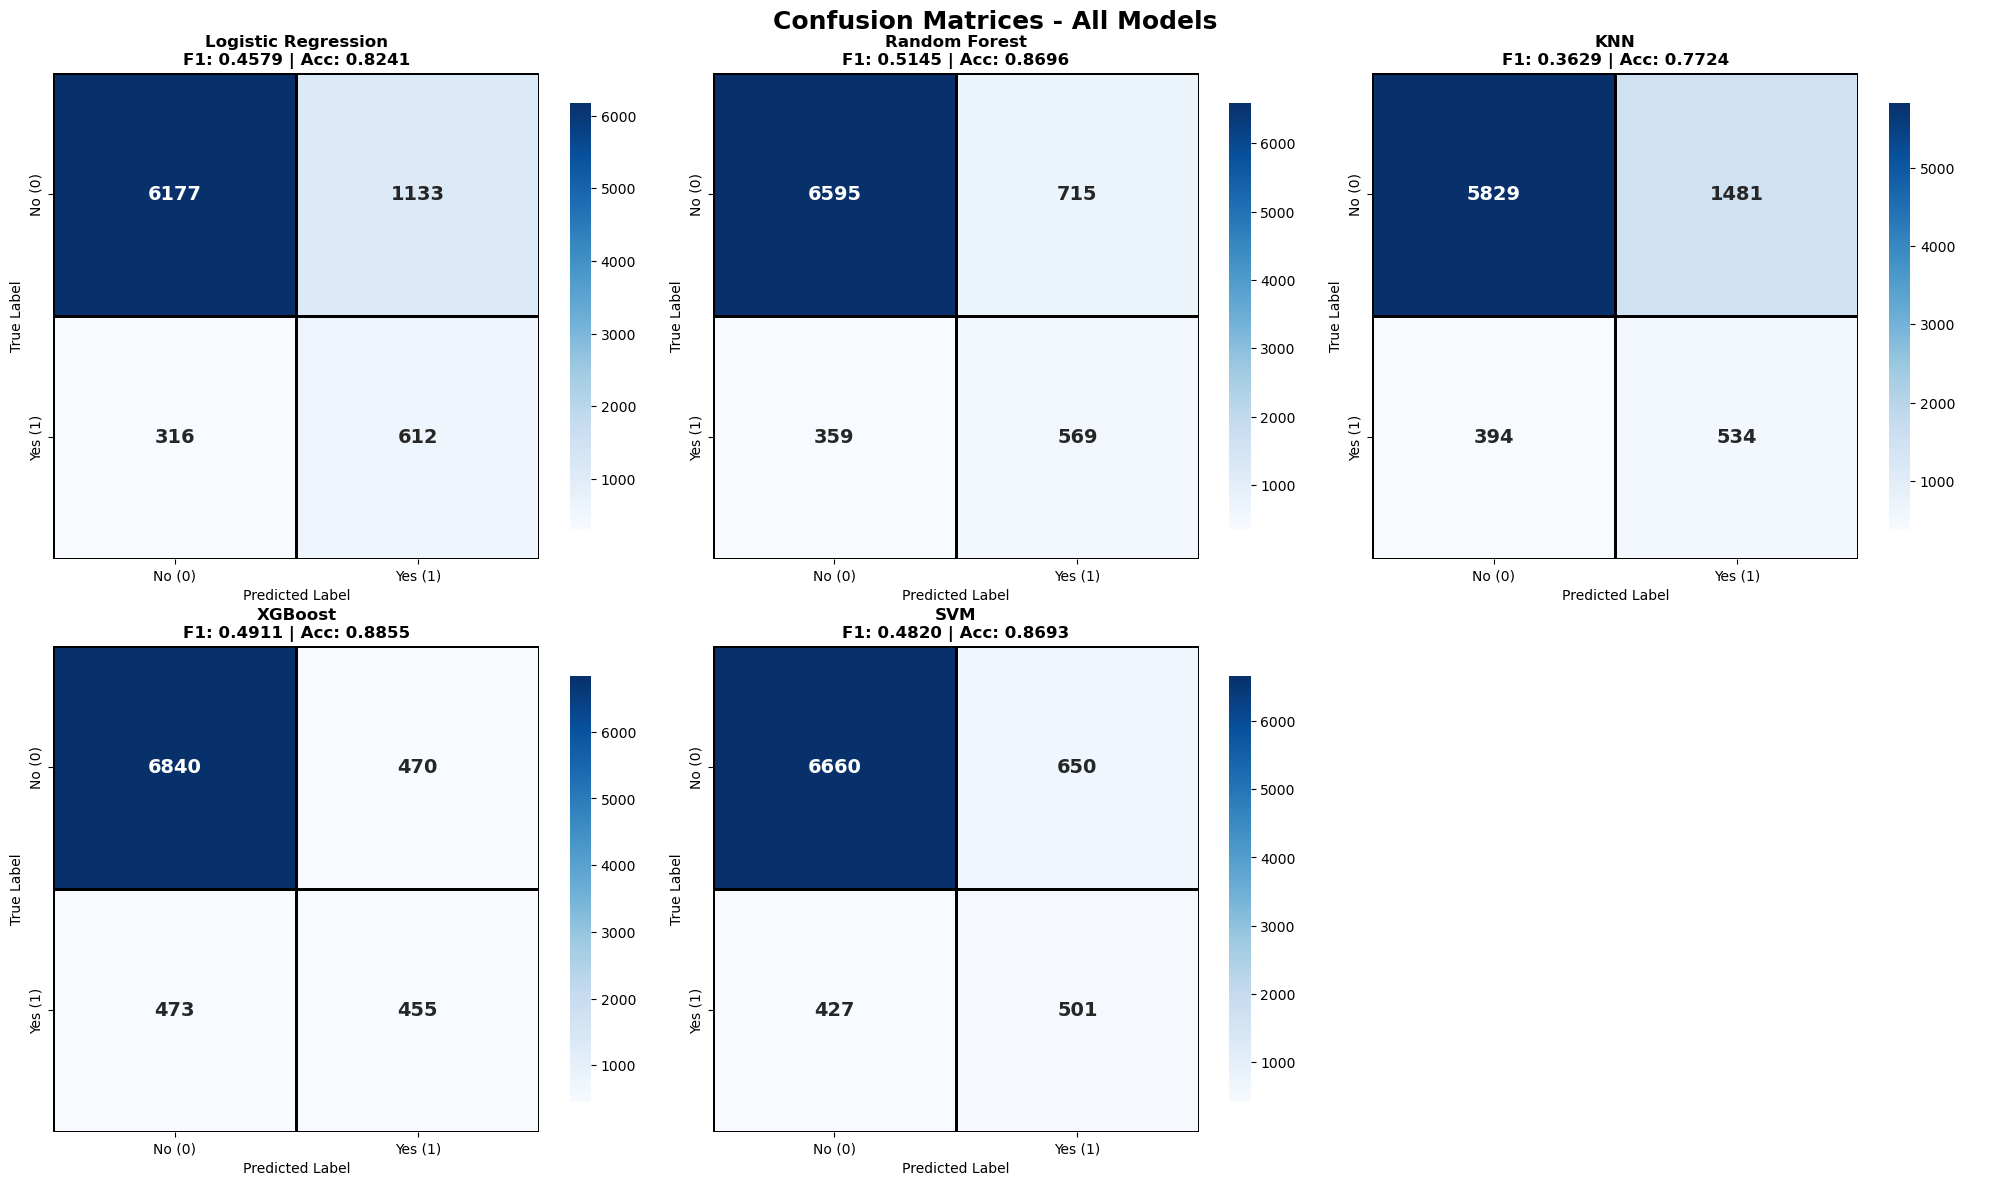

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    
    # Generate predictions from stored trained model
    y_pred = result['model'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        ax=axes[idx], cbar=True, square=True,
        linewidths=2, linecolor='black',
        annot_kws={'size': 14, 'weight': 'bold'},
        cbar_kws={'shrink': 0.8}
    )

    axes[idx].set_title(
        f'{name}\nF1: {result["f1_score"]:.4f} | Acc: {result["accuracy"]:.4f}',
        fontsize=12, fontweight='bold'
    )

    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xticklabels(['No (0)', 'Yes (1)'])
    axes[idx].set_yticklabels(['No (0)', 'Yes (1)'])

axes[5].axis('off')
plt.suptitle('Confusion Matrices - All Models', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


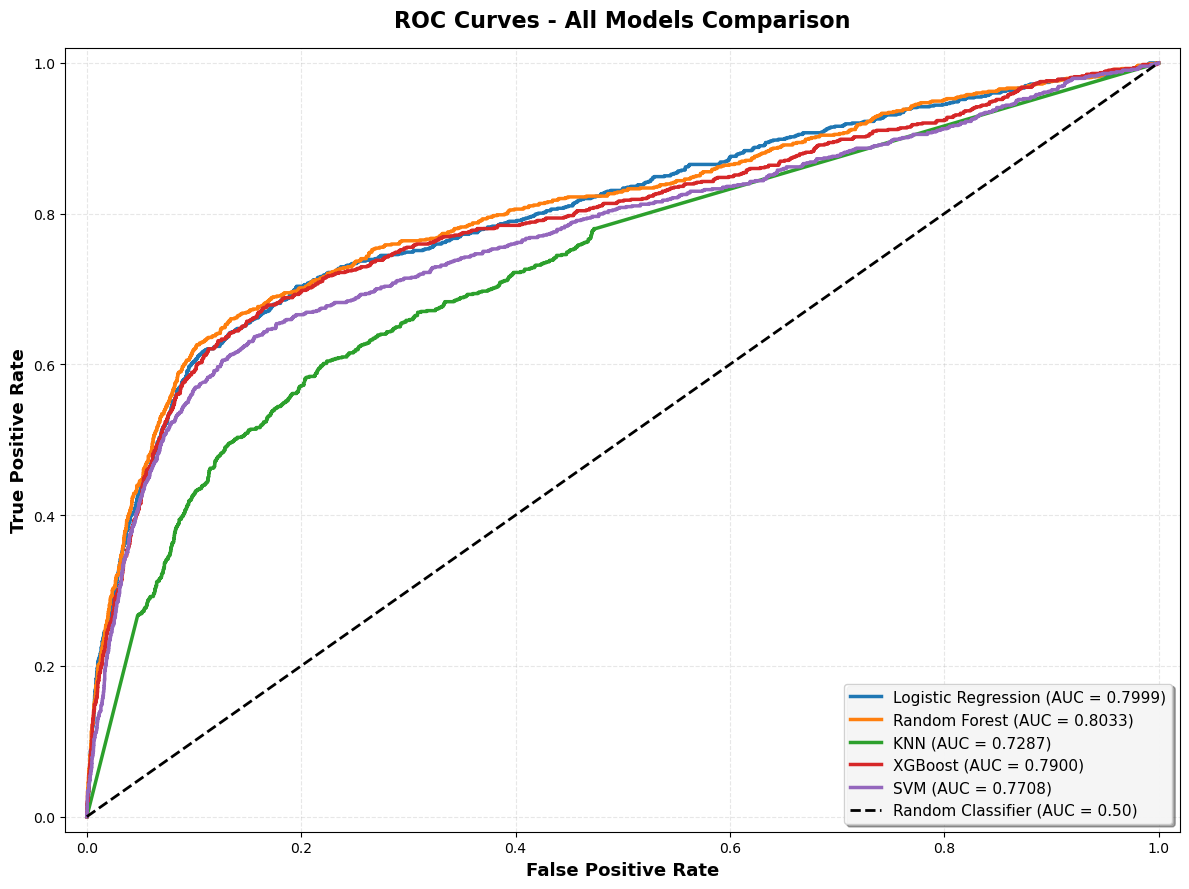

✓ Saved: 12_roc_curves.png


In [114]:
# Visualization 3: ROC Curves for All Models
plt.figure(figsize=(12, 9))

# Plot ROC curve for each model
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2.5, 
             label=f"{name} (AUC = {result['roc_auc']:.4f})")

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models Comparison', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11, framealpha=0.9, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.tight_layout()
plt.savefig('12_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 12_roc_curves.png")

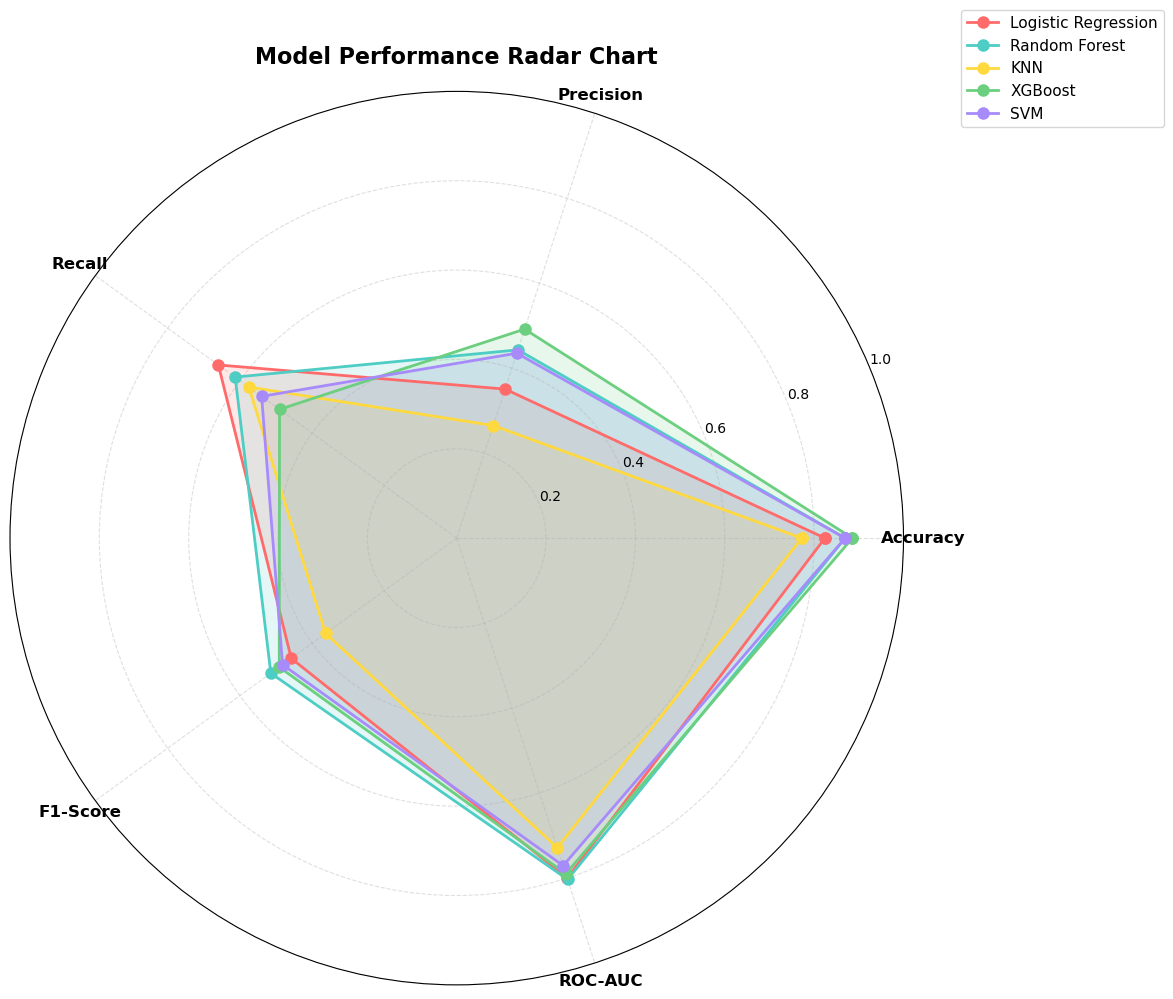

✓ Saved: 13_radar_chart.png


In [116]:
# Visualization 4: Model Comparison Radar Chart
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='polar')

# Angle for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot for each model
colors_radar = ['#FF6B6B', '#4ECDC4', '#FFD93D', '#6BCF7F', '#A78BFA']
for idx, (name, result) in enumerate(results.items()):
    values = [result['accuracy'], result['precision'], result['recall'], 
              result['f1_score'], result['roc_auc']]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=name, 
            color=colors_radar[idx], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

# Fix axis to go from 0 to 1
ax.set_ylim(0, 1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, linestyle='--', alpha=0.4)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Model Performance Radar Chart', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('13_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 13_radar_chart.png")


In [120]:
# ============================================================================
# PART 11: FEATURE IMPORTANCE ANALYSIS (PIPELINE VERSION)
# ============================================================================

print(f"\n{'='*100}")
print("11. FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*100}")

# Extract trained Random Forest model from pipeline
rf_pipeline = results['Random Forest']['model']
rf_model = rf_pipeline.named_steps['model']

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nTop 20 Most Important Features (Random Forest):")
print("="*100)
print(feature_importance.head(20).to_string(index=False))

# Cumulative importance
feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum()

n_features_90 = (feature_importance['Cumulative_Importance'] <= 0.90).sum() + 1

print(f"\nNumber of features needed for 90% importance: {n_features_90}")
print(f"This represents {n_features_90/len(X.columns)*100:.1f}% of all features")



11. FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features (Random Forest):
                      Feature  Importance
                    euribor3m    0.149823
                  nr.employed    0.128014
                 emp.var.rate    0.112246
                cons.conf.idx    0.075975
               cons.price.idx    0.051201
                        pdays    0.044761
  education_university.degree    0.042778
             poutcome_success    0.037752
        education_high.school    0.024510
                  housing_yes    0.023487
                     campaign    0.021004
              day_of_week_wed    0.020847
                          age    0.019236
              marital_married    0.017058
              day_of_week_thu    0.016143
                    month_may    0.015512
              day_of_week_tue    0.015190
               marital_single    0.015066
                     previous    0.014961
education_professional.course    0.014950

Number of features needed for 90% i

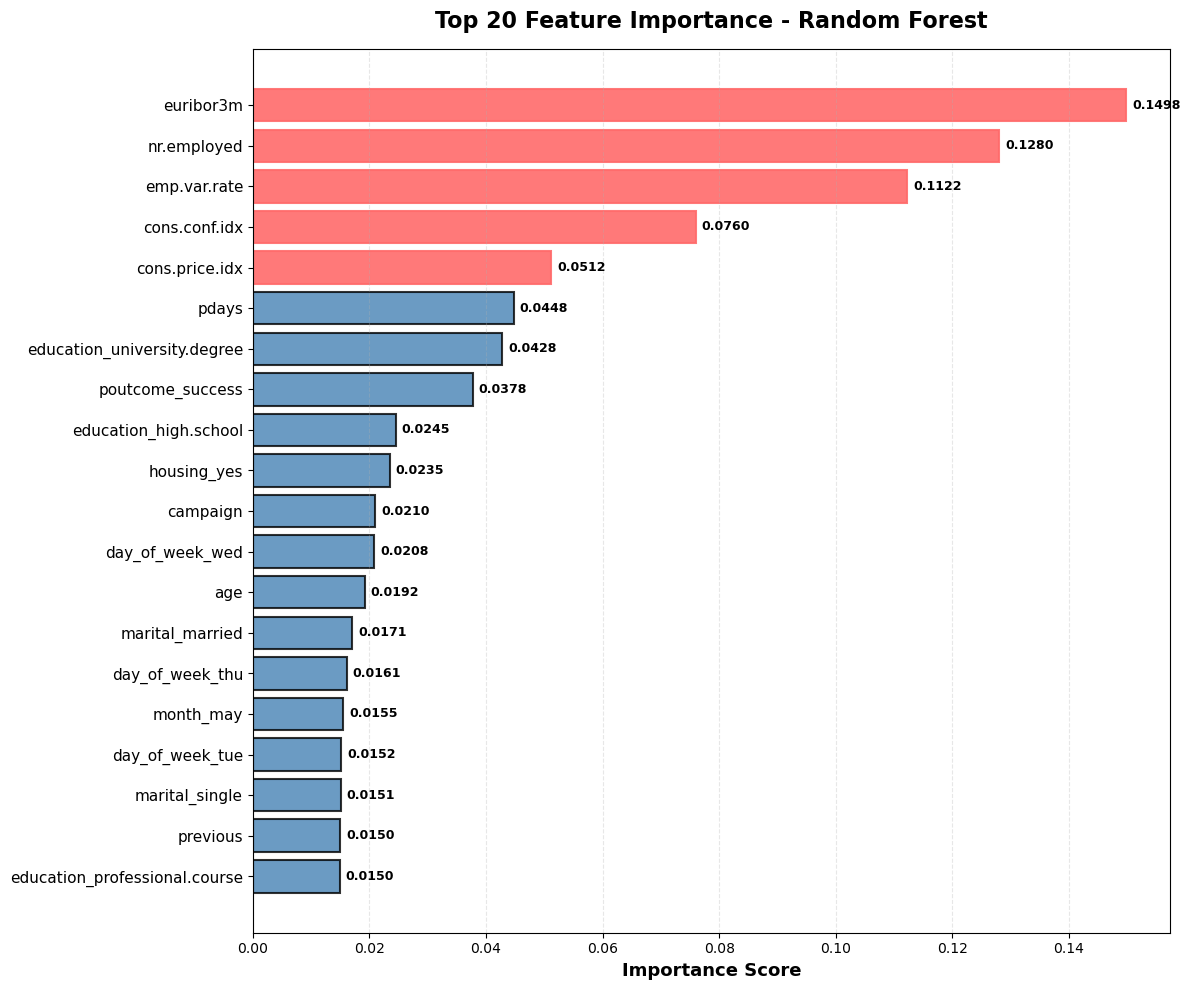


✓ Saved: 14_feature_importance.png


In [122]:
# Visualization 5: Feature Importance Bar Plot
plt.figure(figsize=(12, 10))
top_n = 20
top_features = feature_importance.head(top_n)

bars = plt.barh(range(len(top_features)), top_features['Importance'], 
                color='steelblue', edgecolor='black', alpha=0.8, linewidth=1.5)

# Color the top 5 differently
for i in range(min(5, len(bars))):
    bars[i].set_color('#FF6B6B')
    bars[i].set_alpha(0.9)

plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=11)
plt.xlabel('Importance Score', fontsize=13, fontweight='bold')
plt.title(f'Top {top_n} Feature Importance - Random Forest', 
          fontsize=16, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['Importance'] + 0.001, i, f"{row['Importance']:.4f}", 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('14_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 14_feature_importance.png")

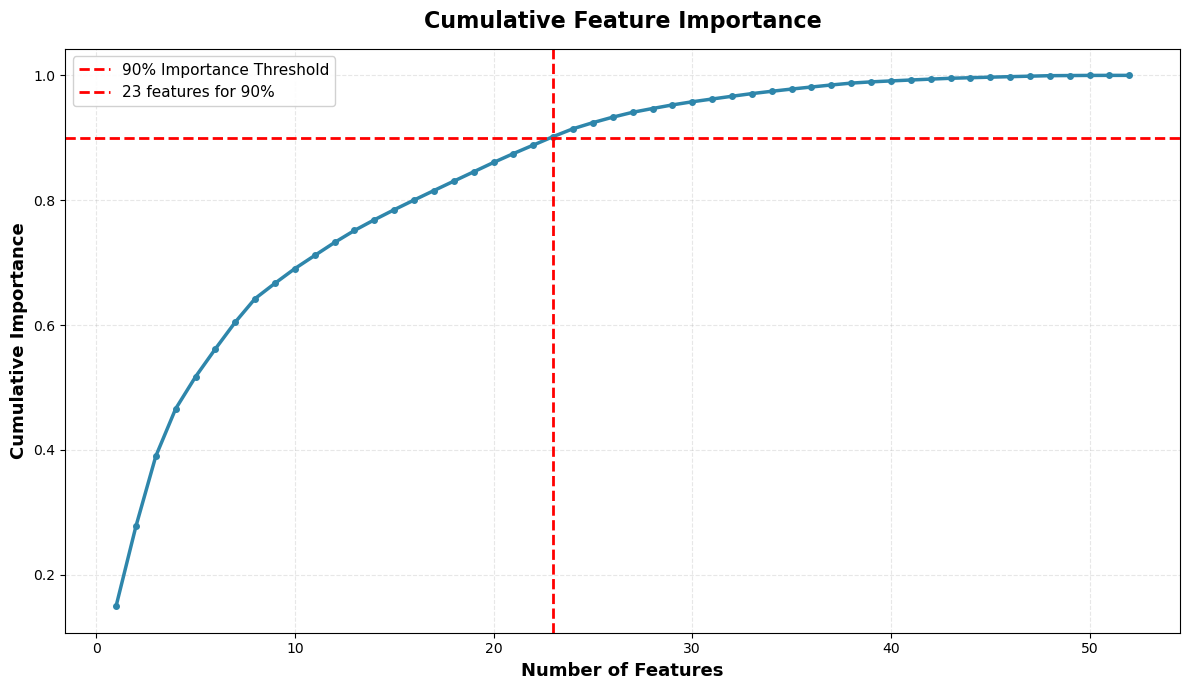

✓ Saved: 15_cumulative_importance.png


In [124]:
# Visualization 6: Cumulative Feature Importance
plt.figure(figsize=(12, 7))

plt.plot(range(1, len(feature_importance) + 1), 
         feature_importance['Cumulative_Importance'], 
         linewidth=2.5, color='#2E86AB', marker='o', markersize=4)

plt.axhline(y=0.90, color='red', linestyle='--', linewidth=2, 
            label='90% Importance Threshold')
plt.axvline(x=n_features_90, color='red', linestyle='--', linewidth=2,
            label=f'{n_features_90} features for 90%')

plt.xlabel('Number of Features', fontsize=13, fontweight='bold')
plt.ylabel('Cumulative Importance', fontsize=13, fontweight='bold')
plt.title('Cumulative Feature Importance', fontsize=16, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig('15_cumulative_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 15_cumulative_importance.png")


In [126]:
# ============================================================================
# PART 12: DETAILED ANALYSIS OF BEST MODEL
# ============================================================================

print(f"\n{'='*100}")
print(f"12. DETAILED ANALYSIS - {best_model_name}")
print(f"{'='*100}")

best_result = results[best_model_name]

print("\nClassification Report:")
print("="*100)
print(classification_report(y_test, best_result['y_pred'], 
                          target_names=['No Subscription (0)', 'Subscription (1)'],
                          digits=4))

# Confusion Matrix Analysis
cm_best = confusion_matrix(y_test, best_result['y_pred'])
tn, fp, fn, tp = cm_best.ravel()

print("\nConfusion Matrix Breakdown:")
print("="*100)
print(f"True Negatives (TN):  {tn:,} - Correctly predicted 'No'")
print(f"False Positives (FP): {fp:,} - Incorrectly predicted 'Yes' (Type I Error)")
print(f"False Negatives (FN): {fn:,} - Incorrectly predicted 'No' (Type II Error)")
print(f"True Positives (TP):  {tp:,} - Correctly predicted 'Yes'")

print("\nDerived Metrics:")
print(f"Specificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"Sensitivity (True Positive Rate/Recall): {tp/(tp+fn):.4f}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")



12. DETAILED ANALYSIS - Random Forest

Classification Report:
                     precision    recall  f1-score   support

No Subscription (0)     0.9484    0.9022    0.9247      7310
   Subscription (1)     0.4431    0.6131    0.5145       928

           accuracy                         0.8696      8238
          macro avg     0.6958    0.7577    0.7196      8238
       weighted avg     0.8915    0.8696    0.8785      8238


Confusion Matrix Breakdown:
True Negatives (TN):  6,595 - Correctly predicted 'No'
False Positives (FP): 715 - Incorrectly predicted 'Yes' (Type I Error)
False Negatives (FN): 359 - Incorrectly predicted 'No' (Type II Error)
True Positives (TP):  569 - Correctly predicted 'Yes'

Derived Metrics:
Specificity (True Negative Rate): 0.9022
Sensitivity (True Positive Rate/Recall): 0.6131
False Positive Rate: 0.0978
False Negative Rate: 0.3869


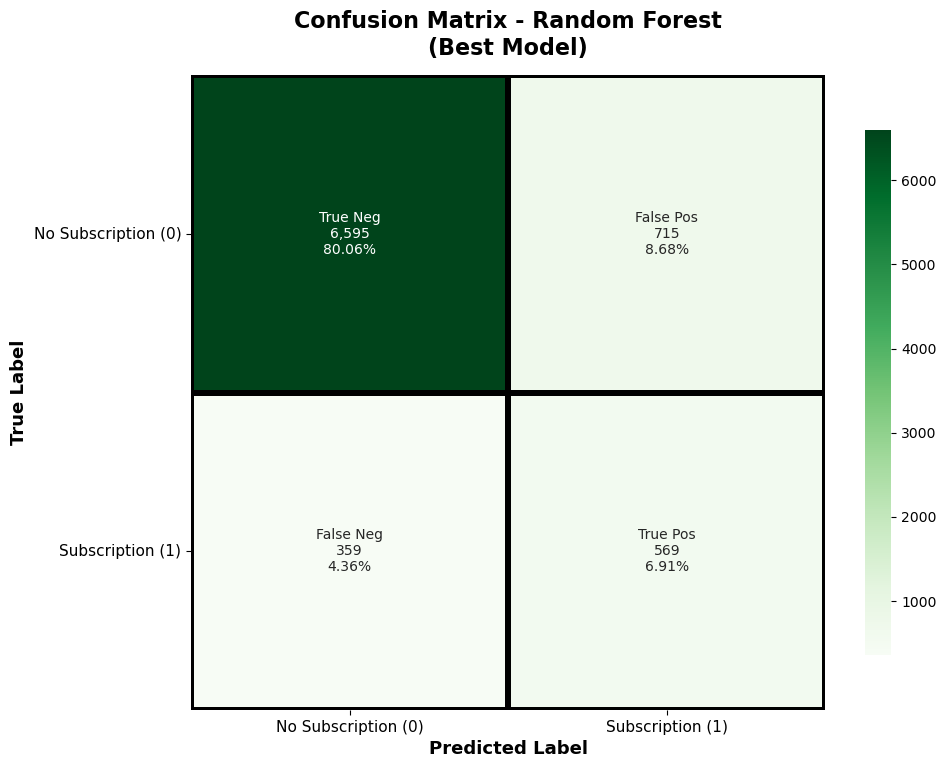


✓ Saved: 16_best_model_confusion_matrix.png


In [128]:
# Visualization 7: Best Model Confusion Matrix (Enhanced)
plt.figure(figsize=(10, 8))

# Create labels with percentages
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f'{value:,}' for value in cm_best.ravel()]
group_percentages = [f'{value:.2%}' for value in cm_best.ravel()/np.sum(cm_best)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm_best, annot=labels, fmt='', cmap='Greens', 
            square=True, cbar=True, linewidths=3, linecolor='black',
            cbar_kws={'shrink': 0.8})

plt.title(f'Confusion Matrix - {best_model_name}\n(Best Model)', 
          fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks([0.5, 1.5], ['No Subscription (0)', 'Subscription (1)'], fontsize=11)
plt.yticks([0.5, 1.5], ['No Subscription (0)', 'Subscription (1)'], 
           rotation=0, fontsize=11)
plt.tight_layout()
plt.savefig('16_best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 16_best_model_confusion_matrix.png")

In [81]:
print(f"\n{'='*100}")
print("13. BUSINESS INSIGHTS AND RECOMMENDATIONS")
print(f"{'='*100}")

print("\nKEY FINDINGS:")
print("-"*100)

# Calculate business metrics
total_customers = len(y_test)
predicted_yes = best_result['y_pred'].sum()
actual_yes = y_test.sum()
correctly_identified = tp

print(f"\n1. MODEL PERFORMANCE:")
print(f"   • Out of {total_customers:,} test customers")
print(f"   • Model predicted {predicted_yes:,} would subscribe")
print(f"   • Actually {actual_yes:,} subscribed")
print(f"   • Model correctly identified {correctly_identified:,} subscribers ({correctly_identified/actual_yes*100:.1f}%)")

print(f"\n2. EFFICIENCY GAINS:")
print(f"   • Without model: Need to call all {total_customers:,} customers")
print(f"   • With model: Call only {predicted_yes:,} predicted customers")
print(f"   • Reduction in calls: {total_customers - predicted_yes:,} ({(total_customers - predicted_yes)/total_customers*100:.1f}%)")
print(f"   • Precision: {best_result['precision']:.1%} of predicted customers will actually subscribe")

print(f"\n3. TOP PREDICTIVE FEATURES:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']:30s} - {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")

print(f"\n4. RECOMMENDATIONS:")
print("   ✓ Use model to prioritize customer calls")
print("   ✓ Focus on customers with high prediction probability")
print(f"   ✓ Monitor top {n_features_90} features closely (90% importance)")
print("   ✓ Retrain model periodically with new campaign data")
print("   ✓ Consider A/B testing with model predictions")



13. BUSINESS INSIGHTS AND RECOMMENDATIONS

KEY FINDINGS:
----------------------------------------------------------------------------------------------------

1. MODEL PERFORMANCE:
   • Out of 8,238 test customers
   • Model predicted 1,754 would subscribe
   • Actually 928 subscribed
   • Model correctly identified 612 subscribers (65.9%)

2. EFFICIENCY GAINS:
   • Without model: Need to call all 8,238 customers
   • With model: Call only 1,754 predicted customers
   • Reduction in calls: 6,484 (78.7%)
   • Precision: 34.9% of predicted customers will actually subscribe

3. TOP PREDICTIVE FEATURES:
   1. euribor3m                      - 0.1266 (12.66%)
   2. campaign                       - 0.0962 (9.62%)
   3. age                            - 0.0730 (7.30%)
   4. housing_yes                    - 0.0659 (6.59%)
   5. nr.employed                    - 0.0631 (6.31%)

4. RECOMMENDATIONS:
   ✓ Use model to prioritize customer calls
   ✓ Focus on customers with high prediction probability

In [79]:
# ============================================================================
# PART 14: EXPORT RESULTS
# ============================================================================

print(f"\n{'='*100}")
print("14. EXPORTING RESULTS")
print(f"{'='*100}")

# Export model comparison
comparison_df.to_csv('model_performance_results.csv', index=False)
print("\n✓ Exported: model_performance_results.csv")

# Export feature importance
feature_importance.to_csv('feature_importance_complete.csv', index=False)
print("✓ Exported: feature_importance_complete.csv")

# Export predictions
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': best_result['y_pred'],
    'Probability': best_result['y_pred_proba']
})
predictions_df.to_csv('best_model_predictions.csv', index=False)
print("✓ Exported: best_model_predictions.csv")


14. EXPORTING RESULTS

✓ Exported: model_performance_results.csv
✓ Exported: feature_importance_complete.csv
✓ Exported: best_model_predictions.csv
